In [1]:
!pip install -r requirements.txt

# Algorithm Explained

In [2]:
from hybridjobs.utility.RetroGateModel import RetroRLModel
from hybridjobs.utility.RetroRLAgent import RetroRLAgent
from hybridjobs.utility.DataPrepare import Prepare
from hybridjobs.utility.BruteForceSearch import expansion, Product, Reaction
import time
import numpy as np
# # Use Braket SDK Cost Tracking to estimate the cost to run this example
# from braket.tracking import Tracker
# t = Tracker().start()

timestamp = time.strftime("%Y%m%d-%H")

In [3]:
# config your aws account in your ~/.aws/config
import os
os.environ['AWS_DEFAULT_REGION']='us-west-1'

#### Step 1: Prepare Data

In this part, we load the retrosynthesis prediction data for experiment.
The [USPTO-50K](https://tdcommons.ai/generation_tasks/retrosyn/#uspto-50k) was 
put in the repository. We assign the relative 
path to **raw_path**.
The **s3_bucket** and **prefix** are used to store the 
results. We can use the one created with the 
cloudformation for convenience.

In [4]:
data_path = 'data'
# download dateset
!mkdir $data_path
!mkdir $data_path\smiles
!wget https://d1o8djwwk7diqy.cloudfront.net/retrosynthetic-plannin-dataset.zip
!unzip -o retrosynthetic-plannin-dataset.zip
# # windows
# !copy retrosynthetic-planning-dataset $data_path
# !copy data\smiles_map.npy  data\smiles\smiles_map.npy

# linux
!cp -r retrosynthetic-planning-dataset/* $data_path
!cp data/smiles_map.npy  data/smiles
!rm retrosynthetic-plannin-dataset.zip 

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘datasmiles’: File exists
--2023-11-27 03:08:39--  https://d1o8djwwk7diqy.cloudfront.net/retrosynthetic-plannin-dataset.zip
Resolving d1o8djwwk7diqy.cloudfront.net (d1o8djwwk7diqy.cloudfront.net)... 108.138.245.167, 108.138.245.103, 108.138.245.206, ...
Connecting to d1o8djwwk7diqy.cloudfront.net (d1o8djwwk7diqy.cloudfront.net)|108.138.245.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3841896 (3.7M) [application/zip]
Saving to: ‘retrosynthetic-plannin-dataset.zip’

100%[======================================>] 3,841,896   --.-K/s   in 0.03s   

2023-11-27 03:08:39 (121 MB/s) - ‘retrosynthetic-plannin-dataset.zip’ saved [3841896/3841896]

Archive:  retrosynthetic-plannin-dataset.zip
  inflating: retrosynthetic-planning-dataset/buyable.npy  
  inflating: retrosynthetic-planning-dataset/target_product.npy  
  inflating: retrosynthetic-planning-dataset/reactions_dictionary.npy 

In [5]:
# input: predata_uspto-50k.xlsx
# output: file1.npy,file2.npy
raw_path = 'data/uspto50k.xlsx'
prepare = Prepare(raw_path)
prepare.generate_files()  # 
prepare.generate_ground_truth()
ground_truth = np.load(prepare.path+'ground_truth.npy', allow_pickle=True).tolist()

INFO:root:Files are present.
INFO:root:All files are generated!
INFO:root:File is present.


#### Step 2: Prepare parameters for agents

In this part, we prepare agent parameters wihch iniclude initial parameters, model parameters and so on

In [6]:
agent_param = {}

In [7]:
# initial the RetroRLModel object
init_param = {}
method = ['retro-rl', 'retro-qrl']

for mt in method:
    if mt == 'retro-rl':
        init_param[mt] = {}
        init_param[mt]['param'] = ['inputsize', 'middlesize', 'outputsize']
    elif mt == 'retro-qrl':
        init_param[mt] = {}
        init_param[mt]['param'] = ['n_qubits', 'device', 'framework', 'shots', 'layers']
    
# retro_rl_model = RetroRLModel(data=None, method=method, **init_param)
agent_param['init_param'] = init_param

In [8]:
model_param={}
method = 'retro-qrl'
model_param[method] = {}
model_param[method]['n_qubits'] = [8]
# model_param[method]['device'] = ['local', 'sv1', 'aspen-m-3', 'aria-2']
model_param[method]['device'] = ['local']
model_param[method]['framework'] = ['pennylane']
# model_param[method]['shots'] = [100,1000]
model_param[method]['shots'] = [100]
# model_param[method]['layers'] = [1,2,3]
model_param[method]['layers'] = [1]


agent_param['model_param'] = model_param

In [9]:
# # uncomment the following parameters if you want to use classical methods
# model_param={}
# method = 'retro-rl'
# model_param[method] = {}
# model_param[method]['inputsize'] = [256]
# # model_param[method]['middlesize'] = [256,512,1024]
# model_param[method]['middlesize'] = [256]
# model_param[method]['outputsize'] = [1]


# agent_param['model_param'] = model_param

In [10]:
from braket.aws import AwsSession

# initial parameters for experiment data
s3_bucket_name = AwsSession().default_bucket() # change to the name of bucket created in your deployment

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [11]:
# train_mode can be: "local-instance", "local-job", "hybrid-job"
train_mode = "hybrid-job"

if method == 'retro-qrl':
    n_qubits = model_param[method]['n_qubits'][0]
    device = model_param[method]['device'][0]
    framework = model_param[method]['framework'][0]
    shots = model_param[method]['shots'][0]
    layers = model_param[method]['layers'][0]
    model_name = "{}_{}_{}_{}_{}".format(n_qubits, device, framework, shots, layers)
else:
    inputsize = model_param[method]['inputsize'][0]
    middlesize = model_param[method]['middlesize'][0]
    outputsize = model_param[method]['outputsize'][0]
    model_name = "{}_{}_{}".format(inputsize, middlesize, outputsize)

data_path = 'data'
# please change the following s3 bucket to the one you can upload and download data
s3_data_path = None

# if train_mode == "local-job" or train_mode == "hybrid-job":
    # s3_bucket_name = "s3://amazon-braket-us-west-1-002224604296"
    # s3_bucket_name = "s3://xxx"
s3_data_path = f"s3://{s3_bucket_name}/data"
import os
os.system(f"aws s3 sync {data_path} {s3_data_path}")

agent_param["data_path"] = data_path
agent_param["s3_data_path"]=s3_data_path
agent_param["train_mode"] = train_mode
agent_param["model_name"] = model_name
# agent_param["model_path"] = model_path
agent_param["episodes"] = 2

retro_model = None

upload: data/Deadend.npy to s3://amazon-braket-us-west-1-067664435707/data/Deadend.npy
upload: data/smiles/smiles_map.npy to s3://amazon-braket-us-west-1-067664435707/data/smiles/smiles_map.npy
upload: data/ground_truth.npy to s3://amazon-braket-us-west-1-067664435707/data/ground_truth.npy
upload: data/target_product.npy to s3://amazon-braket-us-west-1-067664435707/data/target_product.npy
upload: data/reactions_dictionary.npy to s3://amazon-braket-us-west-1-067664435707/data/reactions_dictionary.npy
upload: data/buyable.npy to s3://amazon-braket-us-west-1-067664435707/data/buyable.npy
upload: data/smiles_map.npy to s3://amazon-braket-us-west-1-067664435707/data/smiles_map.npy
upload: data/uspto50k.xlsx to s3://amazon-braket-us-west-1-067664435707/data/uspto50k.xlsx
upload: data/smiles_dictionary.npy to s3://amazon-braket-us-west-1-067664435707/data/smiles_dictionary.npy


In [12]:
# show agent_param
print(agent_param)

{'init_param': {'retro-rl': {'param': ['inputsize', 'middlesize', 'outputsize']}, 'retro-qrl': {'param': ['n_qubits', 'device', 'framework', 'shots', 'layers']}}, 'model_param': {'retro-qrl': {'n_qubits': [8], 'device': ['local'], 'framework': ['pennylane'], 'shots': [100], 'layers': [1]}}, 'data_path': 'data', 's3_data_path': 's3://amazon-braket-us-west-1-067664435707/data', 'train_mode': 'hybrid-job', 'model_name': '8_local_pennylane_100_1', 'episodes': 2}


#### Step 3: Learn Retrosynthetic Planning

In this part, we use cpu to run classical model for retrosynthetic planning 
and simulators/NISQ devices to run quantum model for retrosysnthetic planning.

In [13]:
if train_mode == "local-instance":
    retro_rl_agent = RetroRLAgent(True, method, **agent_param)
    retro_rl_agent.game_job()
    print(f"local instance mode!")
else:
    if method == "retro-qrl":
        retro_rl_agent = RetroRLAgent(False, method, **agent_param)
        retro_rl_agent.game_job()
        job_arn = retro_rl_agent.get_job_arn()
        print(f"create job with arn {job_arn}")
    else:
        retro_rl_agent = RetroRLAgent(True, method, **agent_param)
        retro_rl_agent.game_job()

INFO:root:initial reinforcement learning for retrosynthetic-planning
INFO:root:initial quantum reinforcement learning for retrosynthetic-planning
INFO:root:load data...
INFO:root:build_model is False
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


initial a new agent...
Going to run local mode


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


create job with arn arn:aws:braket:us-west-1:067664435707:job/retrorl-job-local-torch-1701054522


#### Step 4: PostProcess Result

In [14]:
# get results from trained model, let's use the one trained with hybrid job for example

In [15]:
s3_save_path = retro_rl_agent.s3_save_path
agent_name = s3_save_path.split('/')[-1]
data_path = '/'.join(s3_save_path.split('/')[:-1])
agent_name

'8_local_pennylane_100_1_agent_20231127.pt'

In [16]:
s3_save_path

's3://amazon-braket-us-west-1-067664435707/data/8_local_pennylane_100_1_agent_20231127.pt'

In [17]:
!rm -rf pathway_files
!mkdir pathway_files
!aws s3 sync {data_path} pathway_files

download: s3://amazon-braket-us-west-1-067664435707/data/8_local_pennylane_1000_2_agent_20231127.pt to pathway_files/8_local_pennylane_1000_2_agent_20231127.pt
download: s3://amazon-braket-us-west-1-067664435707/data/8_local_pennylane_1000_1_agent_20231127.pt to pathway_files/8_local_pennylane_1000_1_agent_20231127.pt
download: s3://amazon-braket-us-west-1-067664435707/data/8_local_pennylane_1000_3_agent_20231127.pt to pathway_files/8_local_pennylane_1000_3_agent_20231127.pt
download: s3://amazon-braket-us-west-1-067664435707/data/8_local_pennylane_100_1_agent_20231121.pt to pathway_files/8_local_pennylane_100_1_agent_20231121.pt
download: s3://amazon-braket-us-west-1-067664435707/data/8_local_pennylane_100_1_agent_20231127.pt to pathway_files/8_local_pennylane_100_1_agent_20231127.pt
download: s3://amazon-braket-us-west-1-067664435707/data/8_local_pennylane_100_3_agent_20231127.pt to pathway_files/8_local_pennylane_100_3_agent_20231127.pt
download: s3://amazon-braket-us-west-1-0676644

In [18]:
method = "retro-qrl"
# model_name = '8_local_pennylane_100_1'
# retro_rl_model = RetroRLModel.load("pathway_files/retrorl_model_latest.pickle")
retro_model = {"model_name":model_name}
retro_rl_agent = RetroRLAgent(model=False, method=method, load_path="pathway_files", agent_name=agent_name, **agent_param)


INFO:root:initial reinforcement learning for retrosynthetic-planning
INFO:root:initial quantum reinforcement learning for retrosynthetic-planning
INFO:root:load data...


try to load agent from pathway_files for pathway function...


INFO:root:Construct model for n_qubits:8,device:local,framework:pennylane,layers:1 0.0008852680524190267 min


In [19]:
target = 'COC(Cc1ccc2oc(Cc3nc(-c4ccccc4)oc3C)cc2c1)OC'
retro_rl_agent.pathway(target)
layer2 = retro_rl_agent.layer2
# print(layer2)
path = set()
for i, j in layer2.items():
    for k, l  in j.items():
        path.add(l)
print(f"The path of retro_rl_agent: \n \
 {path}")

input_data_path = agent_param["data_path"]
ground_truth = np.load(input_data_path+'/ground_truth.npy', allow_pickle=True).tolist()

real_path = set(ground_truth[target]['path'])
print(f"The real_path of Brute force: \n \
 {real_path}")
real_cost = ground_truth[target]['cost']
print(f"The real_cost of Brute force: \n \
 {real_cost}")
print(f"Get the same path: {path == real_path}")

The path of retro_rl_agent: 
  {'O=[N+]([O-])c1ccc(CO)cc1', 'Cc1ccc(S(=O)(=O)O)cc1', 'COC(Cc1ccc2oc(Cc3nc(-c4ccccc4)oc3C)cc2c1)OC', 'O=C(O)[C@@H]1CCCN1', 'COC=Cc1ccc2oc(Cc3nc(-c4ccccc4)oc3C)cc2c1'}
The real_path of Brute force: 
  {'O=[N+]([O-])c1ccc(CO)cc1', 'Cc1ccc(S(=O)(=O)O)cc1', 'COC(Cc1ccc2oc(Cc3nc(-c4ccccc4)oc3C)cc2c1)OC', 'O=C(O)[C@@H]1CCCN1', 'COC=Cc1ccc2oc(Cc3nc(-c4ccccc4)oc3C)cc2c1'}
The real_cost of Brute force: 
  102.0
Get the same path: True


In [20]:
target = 'O=C(NCc1ccc(CO)cc1)c1ccccn1'
retro_rl_agent.pathway(target)
layer2 = retro_rl_agent.layer2
# print(layer2)
path = set()
for i, j in layer2.items():
    for k, l  in j.items():
        path.add(l)
print(f"The path of retro_rl_agent: \n \
 {path}")

input_data_path = agent_param["data_path"]
ground_truth = np.load(input_data_path+'/ground_truth.npy', allow_pickle=True).tolist()

real_path = set(ground_truth[target]['path'])
print(f"The real_path of Brute force: \n \
 {real_path}")
real_cost = ground_truth[target]['cost']
print(f"The real_cost of Brute force: \n \
 {real_cost}")
print(f"Get the same path: {path == real_path}")

The path of retro_rl_agent: 
  {'N#Cc1ccc(CO)cc1', 'N#Cc1ccc(C=O)cc1', 'NCc1ccc(CO)cc1', 'O=C(O)c1ccccn1', 'O=C(NCc1ccc(CO)cc1)c1ccccn1'}
The real_path of Brute force: 
  {'N#Cc1ccc(CO)cc1', 'N#Cc1ccc(C=O)cc1', 'NCc1ccc(CO)cc1', 'O=C(O)c1ccccn1', 'O=C(NCc1ccc(CO)cc1)c1ccccn1'}
The real_cost of Brute force: 
  3.0
Get the same path: True


In [21]:
target = 'CCCCC(CC)COC(=O)C(C#N)=C(c1ccccc1)c1ccccc1'
retro_rl_agent.pathway(target)
layer2 = retro_rl_agent.layer2
# print(layer2)
path = set()
for i, j in layer2.items():
    for k, l  in j.items():
        path.add(l)
print(f"The path of retro_rl_agent: \n \
 {path}")

input_data_path = agent_param["data_path"]
ground_truth = np.load(input_data_path+'/ground_truth.npy', allow_pickle=True).tolist()

real_path = set(ground_truth[target]['path'])
print(f"The real_path of Brute force: \n \
 {real_path}")
real_cost = ground_truth[target]['cost']
print(f"The real_cost of Brute force: \n \
 {real_cost}")
print(f"Get the same path: {path == real_path}")

The path of retro_rl_agent: 
  {'O=C(c1ccccc1)c1ccccc1', 'CCCCC(CC)COC(=O)C(C#N)=C(c1ccccc1)c1ccccc1', 'CCCCC(CC)COC(=O)CC#N', 'OC(c1ccccc1)c1ccccc1'}
The real_path of Brute force: 
  {'CCCCC(CC)COC(=O)C(C#N)=C(c1ccccc1)c1ccccc1', 'O=C(Cl)c1ccccc1', 'O=C(c1ccccc1)c1ccccc1', 'CCCCC(CC)COC(=O)CC#N', 'c1ccccc1'}
The real_cost of Brute force: 
  2.0
Get the same path: False


# Hybrid Job Experiment

In [22]:
from braket.aws import AwsQuantumJob
from braket.jobs.config import InstanceConfig
import boto3
import json
import time
import altair as alt
import pandas as pd
import numpy as np
from hybridjobs.utility.HybridJobHelpers import *

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


#### Step 1: Prepare parameters for batch evaluation

In this part, we set the parameters for batch evaluation

In [23]:
# parameters for experiments
experiment_name = "retrosynthetic-planning"
data_path = "retrosynthetic-planning-data"
suffix_check = ["txt"]
experiments_params =  {
    "version": "1",
    "params": [
        {"n_qubits": [8]},
        {"framework": ['pennylane']},
        {"layers": [1,2,3]},
        {"shots": [100]},
        {"device": ['local']}
    ]
}

hp = {}
hybrid_job_params = []
parse_params(experiments_params['params'], hp, hybrid_job_params)

print(f"parameters for experiments: \n {hybrid_job_params}")

parameters for experiments: 
 [{'n_qubits': 8, 'framework': 'pennylane', 'layers': 1, 'shots': 100, 'device': 'local'}, {'n_qubits': 8, 'framework': 'pennylane', 'layers': 2, 'shots': 100, 'device': 'local'}, {'n_qubits': 8, 'framework': 'pennylane', 'layers': 3, 'shots': 100, 'device': 'local'}]


In [24]:
# parameters for experiments
experiment_name = "retrosynthetic-planning"
data_path = "retrosynthetic-planning-data"
suffix_check = ["txt"]
experiments_params =  {
    "version": "1",
    "params1": [
        {"n_qubits": [8]},
        {"framework": ['pennylane']},
        {"layers": [1,2,3]},
        {"shots": [100,1000]},
        {"device": ['local']}
    ],
    "params2": [
        {"inputsize": [256]},
        {"middlesize": [256,512,1024]},
        {"outputsize": [1]}
    ]
}

# hp = {}
# hybrid_job_params = []
# parse_params(experiments_params['params'], hp, hybrid_job_params)

# print(f"parameters for experiments: \n {hybrid_job_params}")

hybrid_job_params = []
for n_qubits in experiments_params['params1'][0]["n_qubits"]:
    for framework in experiments_params['params1'][1]["framework"]:
            for layers in experiments_params['params1'][2]["layers"]:
                for shots in experiments_params['params1'][3]["shots"]:
                    for device in experiments_params['params1'][4]["device"]:
                        model_name = "{}_{}_{}_{}_{}".format(n_qubits, device, framework, shots, layers)
                        hybrid_job_params.append(model_name)
for inputsize in experiments_params['params2'][0]["inputsize"]:
    for middlesize in experiments_params['params2'][1]["middlesize"]:
            for outputsize in experiments_params['params2'][2]["outputsize"]:                
                model_name = "{}_{}_{}".format(inputsize, middlesize, outputsize)
                hybrid_job_params.append(model_name)

In [25]:
hybrid_job_params

['8_local_pennylane_100_1',
 '8_local_pennylane_1000_1',
 '8_local_pennylane_100_2',
 '8_local_pennylane_1000_2',
 '8_local_pennylane_100_3',
 '8_local_pennylane_1000_3',
 '256_256_1',
 '256_512_1',
 '256_1024_1']

In [26]:
avtocost = []
# model_path = "./retrorl_model_latest.pickle"

for i in hybrid_job_params:
#     model_name = hybrid_job_params[i]
    model_param = {}
    model_name = i
    if model_name[0] == "8":
        method = "retro-qrl"
        model_param[method] = {}
        model_param[method]['n_qubits'] = [int(model_name.split("_")[0])]
        model_param[method]['device'] = [model_name.split("_")[1]]
        model_param[method]['framework'] = ['pennylane']
        model_param[method]['shots'] = [int(model_name.split("_")[3])]
        model_param[method]['layers'] = [int(model_name.split("_")[4])]
    else:
        method = "retro-rl"
        model_param[method] = {}
        model_param[method]['inputsize'] = [int(model_name.split("_")[0])]
        model_param[method]['middlesize'] = [int(model_name.split("_")[1])]
        model_param[method]['outputsize'] = [int(model_name.split("_")[2])]
        
    agent_param['model_param'] = model_param
    # train_mode can be: "local-instance", "local-job", "hybrid-job"
    train_mode = "hybrid-job"

    data_path = 'data'
    # agent_param = {}
    agent_param["data_path"] = data_path
    agent_param["train_mode"] = train_mode
    agent_param["model_name"] = model_name
    agent_param["episodes"] = 2
    # agent_param["model_path"] = model_path
    
    print(agent_param)
    
    if train_mode == "local-instance":
        retro_rl_agent = RetroRLAgent(True, method, **agent_param)
        retro_rl_agent.game_job()
    else:
        if method == "retro-qrl":
            retro_rl_agent = RetroRLAgent(False, method, **agent_param)
            retro_rl_agent.game_job()
            avtocost.append(retro_rl_agent.avtocost)
        else:
            retro_rl_agent = RetroRLAgent(True, method, **agent_param)
            retro_rl_agent.game_job()
            avtocost.append(retro_rl_agent.avtocost)

    while not queue_check(avtocost):
        time.sleep(5)

INFO:root:initial reinforcement learning for retrosynthetic-planning
INFO:root:initial quantum reinforcement learning for retrosynthetic-planning
INFO:root:load data...
INFO:root:build_model is False
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


{'init_param': {'retro-rl': {'param': ['inputsize', 'middlesize', 'outputsize']}, 'retro-qrl': {'param': ['n_qubits', 'device', 'framework', 'shots', 'layers']}}, 'model_param': {'retro-qrl': {'n_qubits': [8], 'device': ['local'], 'framework': ['pennylane'], 'shots': [100], 'layers': [1]}}, 'data_path': 'data', 's3_data_path': 's3://amazon-braket-us-west-1-067664435707/data', 'train_mode': 'hybrid-job', 'model_name': '8_local_pennylane_100_1', 'episodes': 2}
initial a new agent...
Going to run local mode


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:root:initial reinforcement learning for retrosynthetic-planning
INFO:root:initial quantum reinforcement learning for retrosynthetic-planning
INFO:root:load data...
INFO:root:build_model is False
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


There are 2 jobs in RUNNING or QUEUED status
{'init_param': {'retro-rl': {'param': ['inputsize', 'middlesize', 'outputsize']}, 'retro-qrl': {'param': ['n_qubits', 'device', 'framework', 'shots', 'layers']}}, 'model_param': {'retro-qrl': {'n_qubits': [8], 'device': ['local'], 'framework': ['pennylane'], 'shots': [1000], 'layers': [1]}}, 'data_path': 'data', 's3_data_path': 's3://amazon-braket-us-west-1-067664435707/data', 'train_mode': 'hybrid-job', 'model_name': '8_local_pennylane_1000_1', 'episodes': 2}
initial a new agent...
Going to run local mode


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:root:initial reinforcement learning for retrosynthetic-planning
INFO:root:initial quantum reinforcement learning for retrosynthetic-planning
INFO:root:load data...
INFO:root:build_model is False
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


There are 3 jobs in RUNNING or QUEUED status
{'init_param': {'retro-rl': {'param': ['inputsize', 'middlesize', 'outputsize']}, 'retro-qrl': {'param': ['n_qubits', 'device', 'framework', 'shots', 'layers']}}, 'model_param': {'retro-qrl': {'n_qubits': [8], 'device': ['local'], 'framework': ['pennylane'], 'shots': [100], 'layers': [2]}}, 'data_path': 'data', 's3_data_path': 's3://amazon-braket-us-west-1-067664435707/data', 'train_mode': 'hybrid-job', 'model_name': '8_local_pennylane_100_2', 'episodes': 2}
initial a new agent...
Going to run local mode
There are 4 jobs in RUNNING or QUEUED status
There are 4 jobs in RUNNING or QUEUED status
There are 4 jobs in RUNNING or QUEUED status
There are 4 jobs in RUNNING or QUEUED status
There are 4 jobs in RUNNING or QUEUED status
There are 4 jobs in RUNNING or QUEUED status
There are 4 jobs in RUNNING or QUEUED status
There are 4 jobs in RUNNING or QUEUED status
There are 4 jobs in RUNNING or QUEUED status
There are 4 jobs in RUNNING or QUEUED st

INFO:root:initial reinforcement learning for retrosynthetic-planning
INFO:root:initial quantum reinforcement learning for retrosynthetic-planning
INFO:root:load data...
INFO:root:build_model is False
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


There are 1 jobs in RUNNING or QUEUED status
{'init_param': {'retro-rl': {'param': ['inputsize', 'middlesize', 'outputsize']}, 'retro-qrl': {'param': ['n_qubits', 'device', 'framework', 'shots', 'layers']}}, 'model_param': {'retro-qrl': {'n_qubits': [8], 'device': ['local'], 'framework': ['pennylane'], 'shots': [1000], 'layers': [2]}}, 'data_path': 'data', 's3_data_path': 's3://amazon-braket-us-west-1-067664435707/data', 'train_mode': 'hybrid-job', 'model_name': '8_local_pennylane_1000_2', 'episodes': 2}
initial a new agent...
Going to run local mode


INFO:root:initial reinforcement learning for retrosynthetic-planning
INFO:root:initial quantum reinforcement learning for retrosynthetic-planning
INFO:root:load data...
INFO:root:build_model is False
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


There are 2 jobs in RUNNING or QUEUED status
{'init_param': {'retro-rl': {'param': ['inputsize', 'middlesize', 'outputsize']}, 'retro-qrl': {'param': ['n_qubits', 'device', 'framework', 'shots', 'layers']}}, 'model_param': {'retro-qrl': {'n_qubits': [8], 'device': ['local'], 'framework': ['pennylane'], 'shots': [100], 'layers': [3]}}, 'data_path': 'data', 's3_data_path': 's3://amazon-braket-us-west-1-067664435707/data', 'train_mode': 'hybrid-job', 'model_name': '8_local_pennylane_100_3', 'episodes': 2}
initial a new agent...
Going to run local mode


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:root:initial reinforcement learning for retrosynthetic-planning
INFO:root:initial quantum reinforcement learning for retrosynthetic-planning
INFO:root:load data...
INFO:root:build_model is False
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


There are 3 jobs in RUNNING or QUEUED status
{'init_param': {'retro-rl': {'param': ['inputsize', 'middlesize', 'outputsize']}, 'retro-qrl': {'param': ['n_qubits', 'device', 'framework', 'shots', 'layers']}}, 'model_param': {'retro-qrl': {'n_qubits': [8], 'device': ['local'], 'framework': ['pennylane'], 'shots': [1000], 'layers': [3]}}, 'data_path': 'data', 's3_data_path': 's3://amazon-braket-us-west-1-067664435707/data', 'train_mode': 'hybrid-job', 'model_name': '8_local_pennylane_1000_3', 'episodes': 2}
initial a new agent...
Going to run local mode


INFO:root:initial reinforcement learning for retrosynthetic-planning
INFO:root:initial quantum reinforcement learning for retrosynthetic-planning
INFO:root:load data...
INFO:root:build_model is True
INFO:root:Construct model for inputsize:256,middlesize:256,outputsize:1 1.224676767985026e-05 min


There are 3 jobs in RUNNING or QUEUED status
{'init_param': {'retro-rl': {'param': ['inputsize', 'middlesize', 'outputsize']}, 'retro-qrl': {'param': ['n_qubits', 'device', 'framework', 'shots', 'layers']}}, 'model_param': {'retro-rl': {'inputsize': [256], 'middlesize': [256], 'outputsize': [1]}}, 'data_path': 'data', 's3_data_path': 's3://amazon-braket-us-west-1-067664435707/data', 'train_mode': 'hybrid-job', 'model_name': '256_256_1', 'episodes': 2}
initial a new agent...
model_param is {'retro-rl': {'inputsize': [256], 'middlesize': [256], 'outputsize': [1]}}
episode 1
epsiode 1 training...
finish epoch 0 for 0.002912898858388265 minutes
finish epoch 1 for 4.4790903727213543e-05 minutes


INFO:root:initial reinforcement learning for retrosynthetic-planning
INFO:root:initial quantum reinforcement learning for retrosynthetic-planning
INFO:root:load data...
INFO:root:build_model is True
INFO:root:Construct model for inputsize:256,middlesize:512,outputsize:1 1.8103917439778647e-05 min


There are 3 jobs in RUNNING or QUEUED status
{'init_param': {'retro-rl': {'param': ['inputsize', 'middlesize', 'outputsize']}, 'retro-qrl': {'param': ['n_qubits', 'device', 'framework', 'shots', 'layers']}}, 'model_param': {'retro-rl': {'inputsize': [256], 'middlesize': [512], 'outputsize': [1]}}, 'data_path': 'data', 's3_data_path': 's3://amazon-braket-us-west-1-067664435707/data', 'train_mode': 'hybrid-job', 'model_name': '256_512_1', 'episodes': 2}
initial a new agent...
model_param is {'retro-rl': {'inputsize': [256], 'middlesize': [512], 'outputsize': [1]}}
episode 1
epsiode 1 training...
finish epoch 0 for 2.8383731842041015e-05 minutes
finish epoch 1 for 2.0293394724527993e-05 minutes


INFO:root:initial reinforcement learning for retrosynthetic-planning
INFO:root:initial quantum reinforcement learning for retrosynthetic-planning
INFO:root:load data...
INFO:root:build_model is True
INFO:root:Construct model for inputsize:256,middlesize:1024,outputsize:1 2.7056535085042318e-05 min


There are 3 jobs in RUNNING or QUEUED status
{'init_param': {'retro-rl': {'param': ['inputsize', 'middlesize', 'outputsize']}, 'retro-qrl': {'param': ['n_qubits', 'device', 'framework', 'shots', 'layers']}}, 'model_param': {'retro-rl': {'inputsize': [256], 'middlesize': [1024], 'outputsize': [1]}}, 'data_path': 'data', 's3_data_path': 's3://amazon-braket-us-west-1-067664435707/data', 'train_mode': 'hybrid-job', 'model_name': '256_1024_1', 'episodes': 2}
initial a new agent...
model_param is {'retro-rl': {'inputsize': [256], 'middlesize': [1024], 'outputsize': [1]}}
episode 1
epsiode 1 training...
finish epoch 0 for 3.6323070526123046e-05 minutes
finish epoch 1 for 2.8304258982340495e-05 minutes
There are 3 jobs in RUNNING or QUEUED status


In [27]:
agent_param

{'init_param': {'retro-rl': {'param': ['inputsize',
    'middlesize',
    'outputsize']},
  'retro-qrl': {'param': ['n_qubits',
    'device',
    'framework',
    'shots',
    'layers']}},
 'model_param': {'retro-rl': {'inputsize': [256],
   'middlesize': [1024],
   'outputsize': [1]}},
 'data_path': 'data',
 's3_data_path': 's3://amazon-braket-us-west-1-067664435707/data',
 'train_mode': 'hybrid-job',
 'model_name': '256_1024_1',
 'episodes': 2}

ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

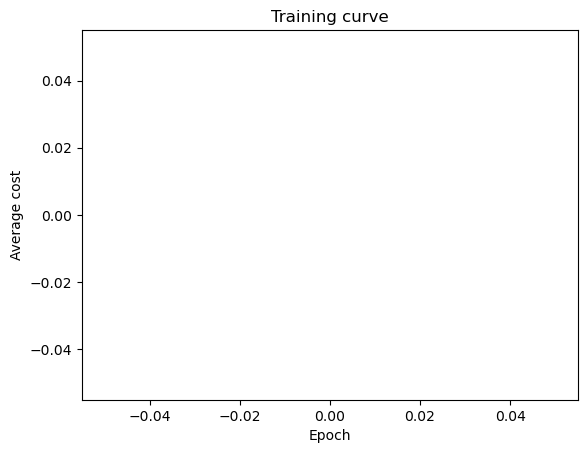

In [28]:
# draw the training curve
import matplotlib.pyplot as plt
plt.figure(1)
plt.title('Training curve')
plt.xlabel('Epoch')
plt.ylabel('Average cost')
for i in range(len(hybrid_job_params)):
    plt.plot(range(0,len(avtocost[0])),avtocost[i],label=hybrid_job_params[i])
plt.legend(loc = 'upper right')